In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import scipy.fftpack

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20,0,10])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [0]:
def generate_time_series(batch_size, n_steps):
    offsets1, offsets2 = np.random.rand(2, batch_size, 1)
    freq1, freq2 = 0.5,0.5
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    return series[..., np.newaxis].astype(np.float32)

np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])


In [0]:
class PlotCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        self.plot_multiple_forecasts(epoch)
    
    def save_fig(self,fig_id, tight_layout=True, fig_extension="png", resolution=300):
        path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
        plt.savefig(path, format=fig_extension, dpi=resolution)


    def plot_multiple_forecasts(self,pic_id):
        np.random.seed(43) 
        n_steps = 50
        s = generate_time_series(1, n_steps + 10)
        X_new, Y_new = s[:, :n_steps], s[:, n_steps:]
        X = X_new
        for step_ahead in range(10):
            y_pred_one = self.model.predict(X[:, step_ahead:])[:, np.newaxis, :]
            X = np.concatenate([X, y_pred_one], axis=1)

        Y_pred = X[:, n_steps:]

        Y = Y_new
        ahead = Y.shape[1]
        plt.figure(1)
        plot_series(X[0, :, 0])
        plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
        plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
        plt.axis([0, n_steps + ahead, -1, 1])
        plt.legend(fontsize=14)
        self.save_fig("predict_plot_"+"%s"%(pic_id))
        plt.figure(2)
        t = np.linspace(0, 1, n_steps+10)
        x = t[n_steps:]
        T = x[-1]-x[0]
        yf = scipy.fftpack.fft(Y_pred.flatten())
        xf = np.linspace(0.0, 1.0/(2.0*T), 10//2)
        plt.plot(xf, 2.0/10 * np.abs(yf[:10//2]))
        self.save_fig("fft_"+"%s"%(pic_id))
        


plot_cb = PlotCallback()


Epoch 1/20
219/219 [==============================] - 21s 95ms/step - loss: 0.0268 - val_loss: 2.5013e-04
Epoch 2/20
219/219 [==============================] - 21s 96ms/step - loss: 1.8917e-04 - val_loss: 9.6701e-05
Epoch 3/20
219/219 [==============================] - 20s 93ms/step - loss: 8.6467e-05 - val_loss: 7.6745e-05
Epoch 4/20
219/219 [==============================] - 20s 93ms/step - loss: 1.0119e-04 - val_loss: 1.0771e-04
Epoch 5/20
219/219 [==============================] - 21s 95ms/step - loss: 4.6387e-05 - val_loss: 9.8878e-05
Epoch 6/20
219/219 [==============================] - 21s 94ms/step - loss: 8.2980e-05 - val_loss: 8.7617e-05
Epoch 7/20
219/219 [==============================] - 20s 93ms/step - loss: 1.9592e-04 - val_loss: 1.6758e-05
Epoch 8/20
219/219 [==============================] - 21s 96ms/step - loss: 8.7993e-05 - val_loss: 1.9256e-05
Epoch 9/20
219/219 [==============================] - 21s 95ms/step - loss: 3.9485e-05 - val_loss: 1.6369e-05
Epoch 10/20
21

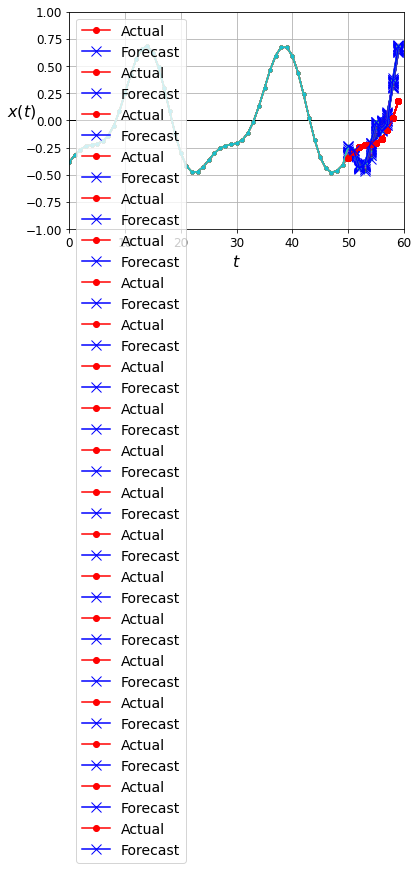

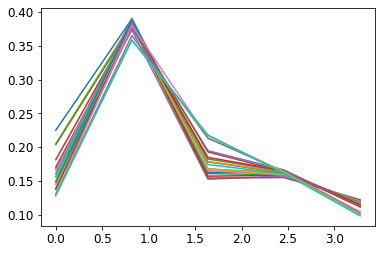

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),callbacks=[plot_cb])

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
model.evaluate(X_valid, y_valid)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [0]:
np.random.seed(43) # not 42, as it would give the first series in the train set

s = generate_time_series(1, n_steps + 10)
X_new, Y_new = s[:, :n_steps], s[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [0]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()